In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import time
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9462.ATS9462 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS9462.reflectometry_controller as reflectometry_contr

import qcodes.instrument_drivers.tektronix.Keithley_2400 as keithley
import qcodes.instrument_drivers.agilent.Agilent_33500B as awg
import qcodes.instrument_drivers.rohde_schwarz.SGS100A as rs_gen

import logging


In [5]:
import visa
rm = visa.ResourceManager()
rm.list_resources()
#rm.close()

('ASRL1::INSTR', 'ASRL10::INSTR', 'GPIB1::10::INSTR')

In [6]:
rm.close()

# Setup instruments

In [2]:
# Create the ATS9626 instrument
alazar = ATSdriver.AlazarTech_ATS9462(name='Alazar')
# Print all information about this Alazar card
#alazar.get_idn()

In [3]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
reflectometry = reflectometry_contr.Reflectometry_Acquisition_Controller(name='reflectometry', 
                                                                    alazar_name='Alazar')
reflectometry.sample_rate(500e3)# for 250MS maximum 5 or 10 averages! 
reflectometry.frequency(83.)
reflectometry.input_coupling('DC')
reflectometry.input_range(2)
reflectometry.impedance(1000000) #use correct impedance depending on amplifier output

In [4]:
sweepgate=awg.Agilent_33500B('AWG', 'GPIB1::10::INSTR', channel=1) 
# set ramp rates
sweepgate.offset.set_step(0.005) #largest changed allowed per set call; 0.01
sweepgate.offset.set_delay(0.3) #delay per set call; 0.3
sweepgate.amplitude.set_step(0.002) #largest changed allowed per set call; 0.01
sweepgate.amplitude.set_delay(0.3) #delay per set call; 0.3
sweepgate.phase.set_step(5) #largest changed allowed per set call; 0.01
sweepgate.phase.set_delay(0.3) #delay per set call; 0.3

Connected to: Agilent Technologies 33522A (serial:MY50005966, firmware:2.03-1.19-2.00-52-00) in 0.10s


In [5]:
stepgate=keithley.Keithley_2400('BG', 'GPIB0::24::INSTR')
# set ramp rates
stepgate.volt.set_step(0.02) #largest changed allowed per set call; 0.01
stepgate.volt.set_delay(0.3) #delay per set call; 0.3

In [41]:
rfgen = rs_gen.RohdeSchwarz_SGS100A('rfgen', 'GPIB0::28::INSTR')

Connected to: Rohde&Schwarz SMB100A (serial:1406.6000k02/103944, firmware:2.2.2.3-2.10.116.18) in 0.08s


# Test Measurement

In [4]:
# config sweep
reflectometry.start(0.4)
reflectometry.end(0.54)
reflectometry.averages(100)

#gate.dcv(1.3)

In [5]:
# Ramp up AWG and setup measurement
reflectometry.setup_AWG(sweepgate) # make sure ramp rates are defined
reflectometry.acquisition.setup_sweep() # needs start, end etc to be defined

In [7]:
# run measurement
data2 = qc.Measure(reflectometry.acquisition).run(name='test')
plot = qc.MatPlot(subplots=(2,1))
plot.add(data2.reflectometry_I)
plot.add(data2.reflectometry_Q, subplot=2)
#plot.add(data2.reflectometry_magnitude, subplot=3)
#plot.add(data2.reflectometry_phase, subplot=4)

RuntimeError: error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [804, 188874752, 5500]

# Reflectometry BG scan 10V-5V 313MHz

In [22]:
# config sweep
reflectometry.start(0.4)
reflectometry.end(0.54)
reflectometry.averages(3000)

# config step
step_start = 10
step_end = 5

In [23]:
# Ramp up AWG and setup measurement
reflectometry.setup_AWG(sweepgate) # make sure ramp rates are defined
reflectometry.acquisition.setup_sweep() # needs start, end etc to be defined

<IPython.core.display.Javascript object>


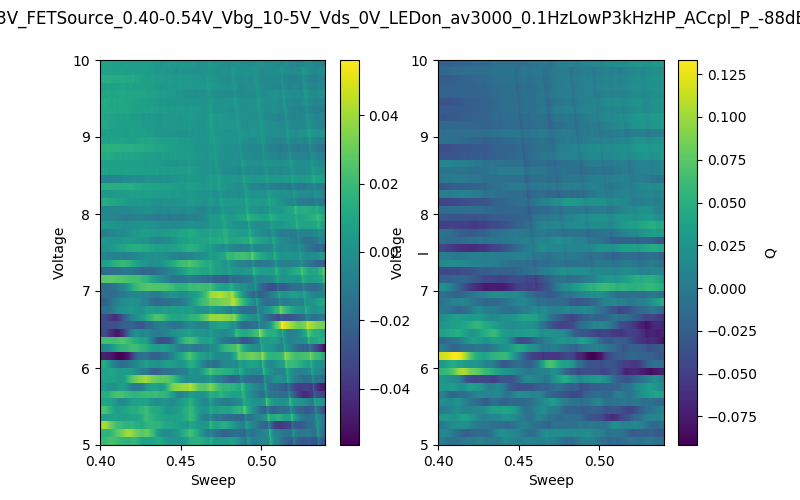

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#006_55mK_FETGate_1.3V_FETSource_0.40-0.54V_Vbg_10-5V_Vds_0V_LEDon_av3000_0.1HzLowP3kHzHP_ACcpl_P_-88dB_f_313MHz_fex_83Hz_Amp_200_12-46-52'
   <Type>   | <array_id>              | <array.name> | <array.shape>
   Setpoint | BG_volt_set             | volt         | (51,)
   Measured | Sweep                   | Sweep        | (51, 3040)
   Measured | reflectometry_I         | I            | (51, 3040)
   Measured | reflectometry_Q         | Q            | (51, 3040)
   Measured | reflectometry_magnitude | magnitude    | (51, 3040)
   Measured | reflectometry_phase     | phase        | (51, 3040)
started at 2017-03-03 13:23:35


In [25]:
# first measurement
loop = qc.Loop(stepgate.volt.sweep(step_start,step_end,step=0.1), 5).each(reflectometry.acquisition)
data2 = loop.get_data_set(name='55mK_FETGate_1.3V_FETSource_0.40-0.54V_Vbg_10-5V_Vds_0V_LEDon_av3000_0.1HzLowP3kHzHP_ACcpl_P_-88dB_f_313MHz_fex_83Hz_Amp_200')
plot = qc.MatPlot(subplots=(1,2))
plot.add(data2.reflectometry_I)
plot.add(data2.reflectometry_Q, subplot=2)
_ = loop.with_bg_task(plot.update, plot.save).run()